An accelerator with m-BPMS and n-correctors produces an m x n dimensional response matrix:
$$C_{mn}=\frac{\sqrt{\beta_m\beta_n}}{2\sin(\pi \nu)}\cos(\pi\nu -\phi(s)+\phi(s_0)) + \frac{\eta_i \eta_j}{\alpha_c L_o}$$
In LOCO the measured orbit response matrix ORM is fitted to the lattice model, to find the proper quadrpoles strengths.


In [1]:
import numpy as np
lattice_name = 'FCCeeV22_z'

ir_quads = np.load("ir_quads.npy") # load ir and arc elements indices
ir_sext = np.load("ir_sext.npy")
arc_quads = np.load("arc_quads.npy")
arc_sext = np.load("arc_sext.npy")

dCx = np.load('dCx.npy') # Jacobian, calculated while sextupoles off
dCy = np.load('dCy.npy')
dCxy = np.load('dCxy.npy')
dCyx = np.load('dCyx.npy')

Rvx = np.load('Rvx.npy') # Inverse ORMs (all correctors used)
Rvy = np.load('Rvy.npy')
num_used_correctors = 10
correctrs_kick = 1.e-6
dk = 1.e-6 # change in quads strengths

misaligned_elements = arc_quads
shiftx = 10.e-6 # Field and alignments error_values
shifty = 10.e-6
sigmaCut = 2.5 #sigma error cut
gradient_errors = 2.e-04
sCut = 1550 # singular value cut

# parameters for DA calculations

dr=0.5
dp=0.0
nturns=100
xp0=0.0
yp0=0.0
eh = 0.71e-9
ev =  1.42e-12

Load the lattice - radiation off


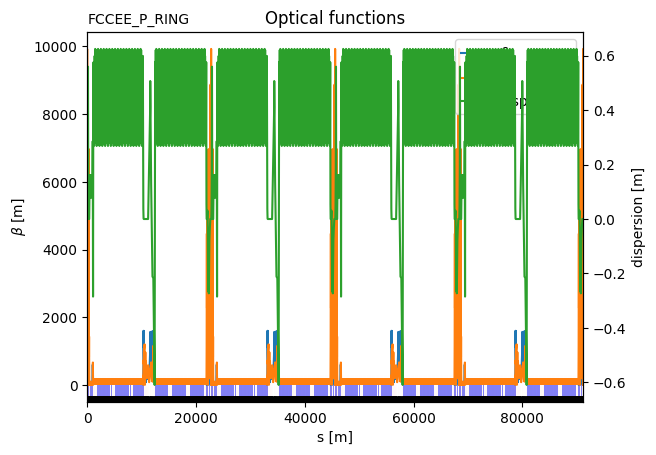

 Turn sext off 
 BPM_to_corrector_response_matrices (Model) ..
 Generate quadrupoles response (Jacobian) ..
The lattice FCCeeV22_z has 1856 BPMs, 1856 Correctors, 3056 Dipoles, and 1856 quadrupoles. Number of used correctors = 10
The ideal lattice tune values: [214.2602333  214.37990634], The chromaticity values: [ -503.4954294  -3179.35187424]. 
theta=0
found DA 18.0 0.0
DA radius is 18.0
theta=10
found DA 18.218943430725847 3.212491286838211
DA radius is 18.5
theta=20
found DA 17.85415979493226 6.498382723187706
DA radius is 19.0
theta=30
found DA 18.186533479473212 10.499999999999998
DA radius is 21.0
theta=40
found DA 18.002044413295984 15.105508827633672
DA radius is 23.5
theta=50
found DA 17.9980530712231 21.449244407331385
DA radius is 28.0
theta=60
found DA 17.750000000000004 30.74390183434757
DA radius is 35.5
theta=70
found DA 17.272017237946276 47.45447734968837
DA radius is 50.5
theta=80
found DA 15.281039634689876 86.66308226507431
DA radius is 88.0
theta=90
found DA 7.745

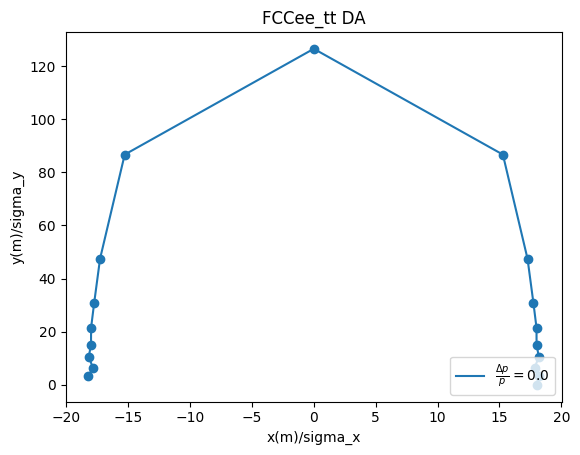

Execution time: 1388.2266669273376 sec
 Introduce errors .. 


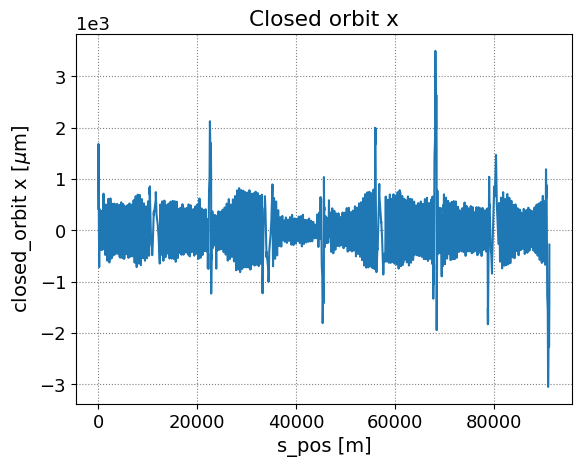

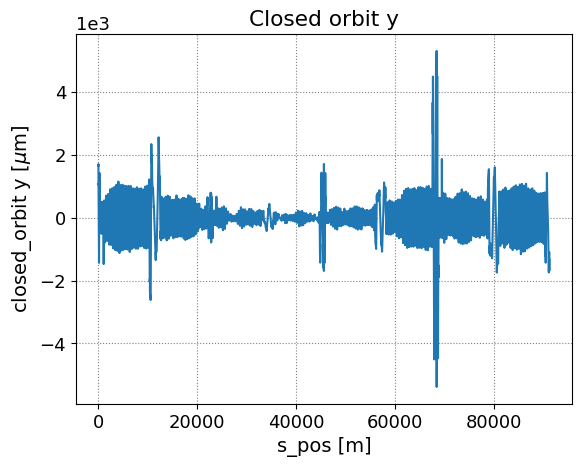

RMS horizontal orbit with errors: 449.3772621680488 mu m,  RMS vertical orbit with errors: 685.6439591295425 mu m
Tune values with errors: [214.2602333  214.37990635], The chromaticity values: [ -503.49574401 -3179.33678784]. 
RMS horizontal beta beating:1.677147099930813e-07%   RMS vertical beta beating: 2.2561130049517792e-05%
theta=0
found DA 14.0 0.0
DA radius is 14.0
theta=10
found DA 14.279712418677017 2.5178985761704897
DA radius is 14.5
theta=20
found DA 14.56523562218158 5.301312221547865
DA radius is 15.5
theta=30
found DA 14.722431864335459 8.499999999999998
DA radius is 17.0
theta=40
found DA 14.93786664082007 12.534358388887515
DA radius is 19.5
theta=50
found DA 15.105508827633676 18.002044413295984
DA radius is 23.5
theta=60
found DA 15.750000000000004 27.279800219209815
DA radius is 31.5
theta=70
found DA 16.416966879632103 45.1052457977236
DA radius is 48.0
theta=80
found DA 15.367863723523342 87.15548614158041
DA radius is 88.5
theta=90
found DA 7.99082036443648e-15 1

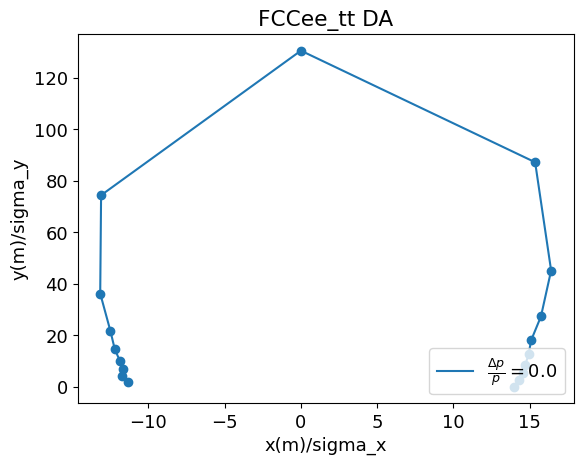

Execution time: 1193.8239603042603 sec


In [2]:
print(f"Load the lattice - radiation off")
from at_modules_loco import *
ring = at.load_mat(lattice_name)
ring.radiation_off()
ring.plot_beta()

# elements indices
quads_indices = get_refpts(ring,at.elements.Quadrupole)
bpm_indices = get_refpts(ring, at.elements.Monitor)
corrector_indices= get_refpts(ring , at.elements.Corrector)
dipole_indices = get_refpts(ring, elements.Dipole)
used_cor_indices = select_equally_spaced_elements(corrector_indices, num_used_correctors)

print(' Turn sext off ')
sext_strengths = []
sext_indexes = get_refpts(ring,at.elements.Sextupole)
for i in sext_indexes:
    sext_strengths.append(ring[i].H)
    ring[i].H = 0.0

print(" BPM_to_corrector_response_matrices (Model) ..")
Cx0, Cxy0, Cy0, Cyx0 = ORMs(correctrs_kick, ring,used_cor_indices)

print(" Generate quadrupoles response (Jacobian) ..") #NOTE: files pre-loaded, the execution of this function is time-consuming

#dCx, dCy, dCxy, dCyx = generatingQuadsResponse(ring,Cx0, Cxy0, Cy0, Cyx0 , correctors_kick,used_cor_indices, quads_indices, dk)

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss = elemdata

print('The lattice {} has {} BPMs, {} Correctors, {} Dipoles, and {} quadrupoles. Number of used correctors = {}'.format(lattice_name, len(bpm_indices), len(corrector_indices), len(dipole_indices), len(quads_indices), len(used_cor_indices)))
nominal_tune = get_tune(ring, get_integer=True)
print(f"The ideal lattice tune values: {nominal_tune}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
print("Dynamic Aperture calculation - nominal")
x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'nominal',showPlot=True, debug=True)

print(" Introduce errors .. ")

simulateShiftErrors(ring, shiftx,shifty, misaligned_elements, sigmaCut,  relative=True)
#simulateFieldErrors(ring, gradient_errors, misaligned_elements)

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss_err = elemdata
ring.save('{}_with_errors.mat'.format(lattice_name), mat_key='ring')
rmsx_err, rmsy_err = rms_orbits(ring, bpm_indices, makeplot = True)
print(f"RMS horizontal orbit with errors: {rmsx_err*1.e6} mu m, ", f"RMS vertical orbit with errors: {rmsy_err*1.e6} mu m")
print(f"Tune values with errors: {get_tune(ring, get_integer=True)}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
bx_rms, by_rms = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
print("RMS horizontal beta beating:" + str(bx_rms * 100) + "%   RMS vertical beta beating: " + str(by_rms * 100) + "%")
print("Dynamic Aperture calculation - with errors")
x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'with_errors',showPlot=True, debug=True)

# Orbit corrections

SVD orbit correction
RMS horizontal orbit with errors: 449.3772621680488 mu m,  RMS vertical orbit with errors: 685.6439591295425 mu m
RMS horizontal orbit after correction: 2.446990137312672 mu m,  RMS vertical orbit after correction: 2.1565819690540065 mu m
Tune values with orbit corrections: [214.2602333  214.37990634], The chromaticity values: [ -503.49542963 -3179.35187709]. 
RMS horizontal beta beating:3.6250697929485604e-10%   RMS vertical beta beating: 1.1924866443177398e-08%


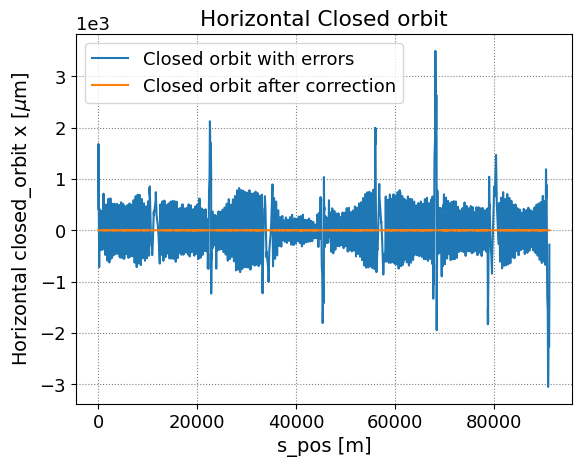

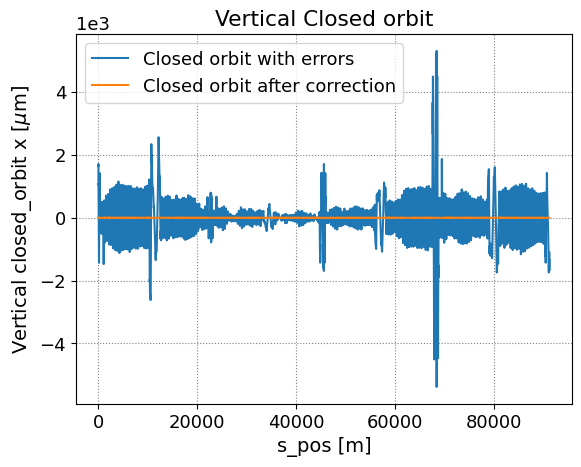

theta=0
found DA 18.0 0.0
DA radius is 18.0
theta=10
found DA 18.218943430725847 3.212491286838211
DA radius is 18.5
theta=20
found DA 18.324006105325214 6.66939279485054
DA radius is 19.5
theta=30
found DA 18.186533479473212 10.499999999999998
DA radius is 21.0
theta=40
found DA 18.002044413295984 15.105508827633672
DA radius is 23.5
theta=50
found DA 17.9980530712231 21.449244407331385
DA radius is 28.0
theta=60
found DA 17.750000000000004 30.74390183434757
DA radius is 35.5
theta=70
found DA 17.272017237946276 47.45447734968837
DA radius is 50.5
theta=80
found DA 15.281039634689876 86.66308226507431
DA radius is 88.0
theta=90
found DA 7.745891004607009e-15 126.5
DA radius is 126.5
theta=100
found DA -15.194215545856402 86.1706783885682
DA radius is 87.5
theta=110
found DA -17.101007166283434 46.98463103929542
DA radius is 50.0
theta=120
found DA -17.749999999999993 30.743901834347575
DA radius is 35.5
theta=130
found DA -17.9980530712231 21.449244407331385
DA radius is 28.0
theta=14

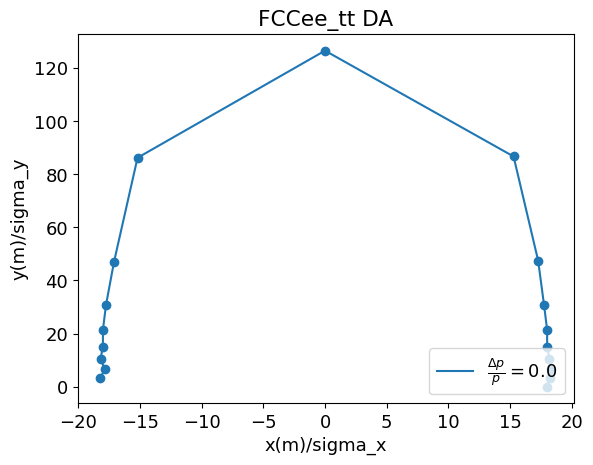

Execution time: 1373.3738541603088 sec


In [3]:
print('SVD orbit correction')
_, _, elemdata = at.get_optics(ring, bpm_indices)
closed_orbitx = elemdata.closed_orbit[:, 0]
closed_orbity = elemdata.closed_orbit[:, 2]
#Corrector_strength
CSx = np.dot(np.transpose(Rvx),-closed_orbitx)
CSy = np.dot(np.transpose(Rvy),-closed_orbity)
for m in range(len(corrector_indices)):
    ring[corrector_indices[m]].KickAngle  = [0,0]
    ring[corrector_indices[m]].KickAngle  = [CSx[m],CSy[m]]

ring.save('{}_orbit_corrected.mat'.format(lattice_name), mat_key='ring')
rmsx_cor, rmsy_cor = rms_orbits(ring, bpm_indices, makeplot = False)
bx_rms_err, by_rms_err = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
print(f"RMS horizontal orbit with errors: {rmsx_err*1.e6} mu m, ", f"RMS vertical orbit with errors: {rmsy_err*1.e6} mu m")
print(f"RMS horizontal orbit after correction: {rmsx_cor*1.e6} mu m, ", f"RMS vertical orbit after correction: {rmsy_cor*1.e6} mu m")
print(f"Tune values with orbit corrections: {get_tune(ring, get_integer=True)}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
print("RMS horizontal beta beating:" + str(bx_rms_err * 100) + "%   RMS vertical beta beating: " + str(by_rms_err * 100) + "%")
corrections_plots(ring ,twiss, twiss_err, 'orbit')
print("Dynamic Aperture calculation - orbit corrected")
x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'orbit_corrected',showPlot=True, debug=True)

# Swich sextupoles ON


Swich sextupoles ON
RMS horizontal orbit with errors: 2.446709554530814 mu m,  RMS vertical orbit with errors: 2.1565843203882475 mu m
RMS horizontal orbit after correction: 2.446709554530814 mu m,  RMS vertical orbit after correction: 2.1565843203882475 mu m
Tune values with orbit corrections: [214.26015795 214.38072218], The chromaticity values: [-0.04601903 -0.14961185]. 
RMS horizontal beta beating:0.48030820584362605%   RMS vertical beta beating: 1.057418739768508%
theta=0
found DA 18.0 0.0
DA radius is 18.0
theta=10
found DA 18.218943430725847 3.212491286838211
DA radius is 18.5
theta=20
found DA 18.324006105325214 6.66939279485054
DA radius is 19.5
theta=30
found DA 18.186533479473212 10.499999999999998
DA radius is 21.0
theta=40
found DA 18.002044413295984 15.105508827633672
DA radius is 23.5
theta=50
found DA 17.9980530712231 21.449244407331385
DA radius is 28.0
theta=60
found DA 18.000000000000004 31.17691453623979
DA radius is 36.0
theta=70
found DA 17.44302730960911 47.9243

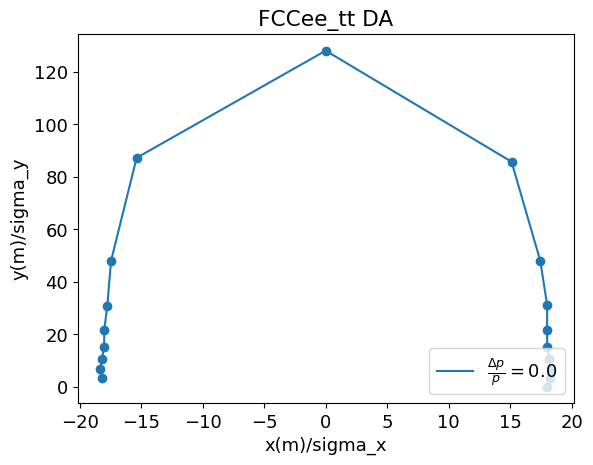

Execution time: 1380.8646495342255 sec


In [4]:
print("Swich sextupoles ON")
for i in range(len(sext_indexes)):
    ring[sext_indexes[i]].H = sext_strengths[i]*1
rmsx, rmsy = rms_orbits(ring, bpm_indices, makeplot = False)
bx_rms_err, by_rms_err = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
print(f"RMS horizontal orbit with errors: {rmsx*1.e6} mu m, ", f"RMS vertical orbit with errors: {rmsy*1.e6} mu m")
print(f"RMS horizontal orbit after correction: {rmsx*1.e6} mu m, ", f"RMS vertical orbit after correction: {rmsy*1.e6} mu m")
print(f"Tune values with orbit corrections: {get_tune(ring, get_integer=True)}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
print("RMS horizontal beta beating:" + str(bx_rms_err* 100) + "%   RMS vertical beta beating: " + str(by_rms_err* 100) + "%")
x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'sext_on',showPlot=True, debug=True)

# LOCO corrections


LOCO

Fitting Tune...
Initial value [214.26015795 214.38072218]
iter# 0 Res. 6.46950164746851e-15
Final value [214.26023329 214.37990626] 

 BPM_to_corrector_response_matrices (Measured) ..
LOCO iterations
Execution time: 554.1486575603485 sec


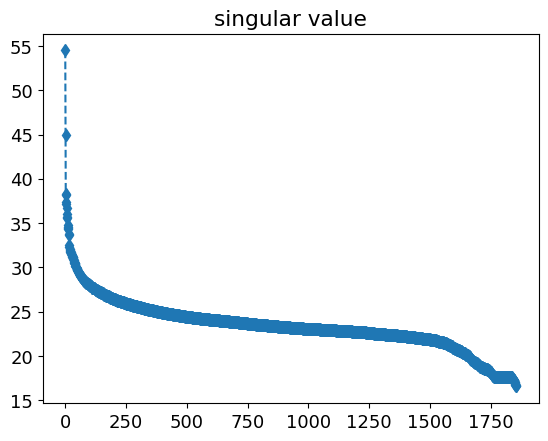

number of singular values 1856


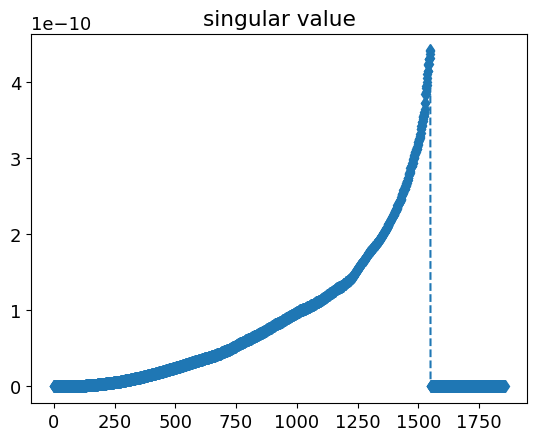

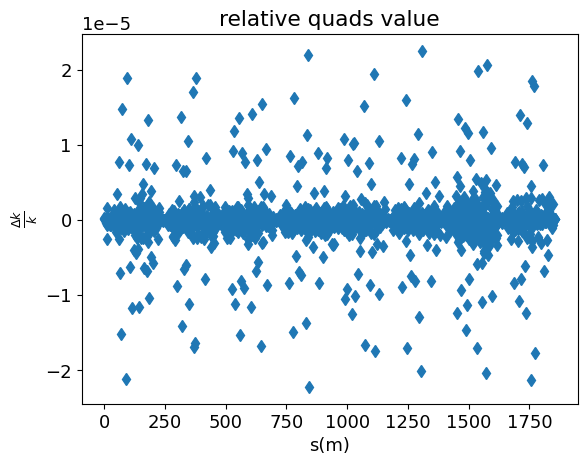

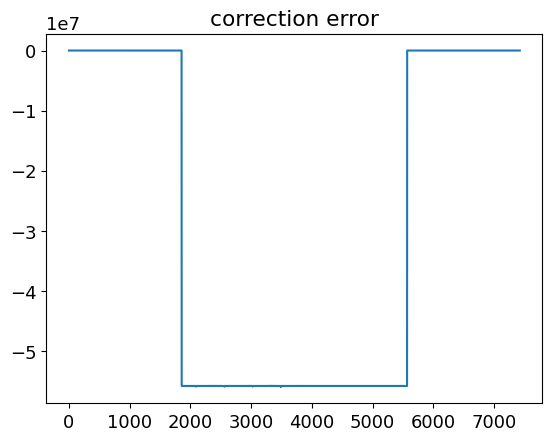

Beta beating before correction :
RMS horizontal beta beating:0.48010563596756156%   RMS vertical beta beating: 1.0506601632975325%
Beta beating after corrections
RMS horizontal beta beating:0.17827195599149842%   RMS vertical beta beating: 5.892462904209595%
beta_x correction reduction 62.868180951005655
beta_x correction reduction -460.83433159927756
RMS horizontal orbit with optics correction: 2.475584527656875 mu m,  RMS vertical orbit with optics correction: 2.161303530750202 mu m
Tune values with optics corrections: [214.26034875 214.38505565], The chromaticity values: [0.03500413 0.52390689]. 


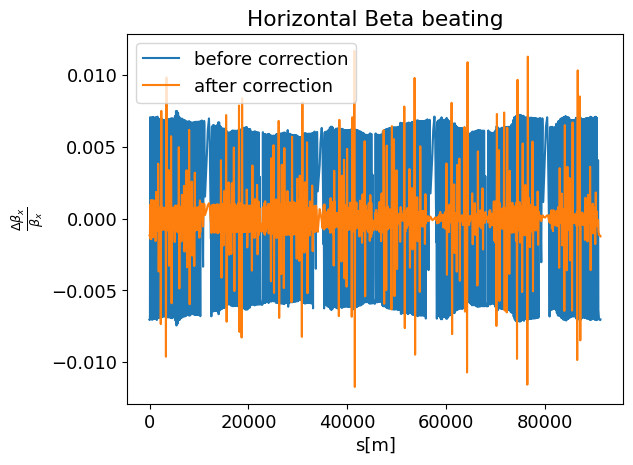

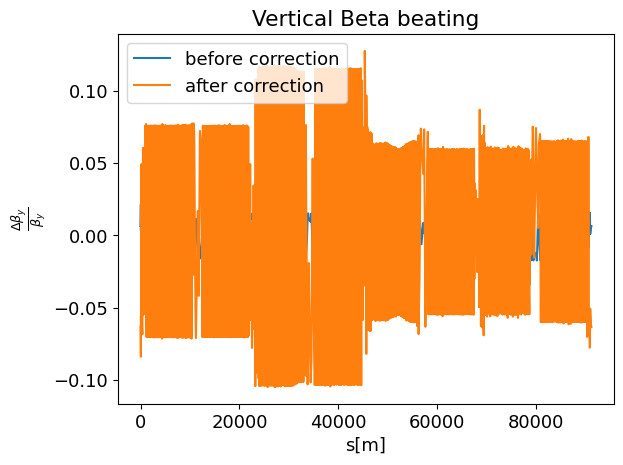


Fitting Tune...
Initial value [214.26034875 214.38505565]
iter# 0 Res. 3.174498424998886e-10
iter# 1 Res. 3.4930237274700184e-15
Final value [214.2602333 214.3799064] 

 BPM_to_corrector_response_matrices (Measured) ..
LOCO iterations
Execution time: 557.3150722980499 sec


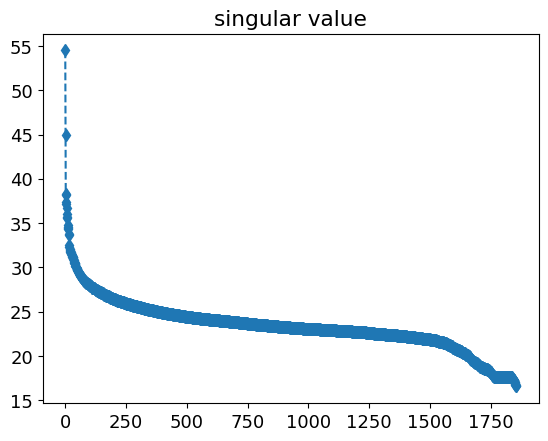

number of singular values 1856


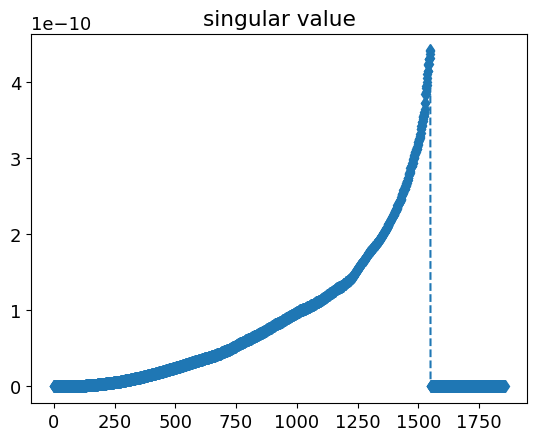

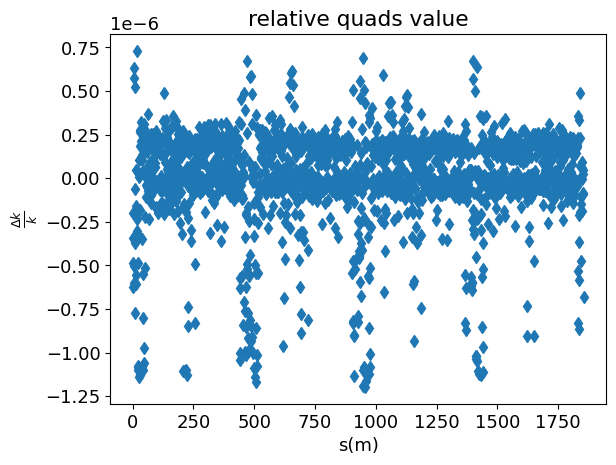

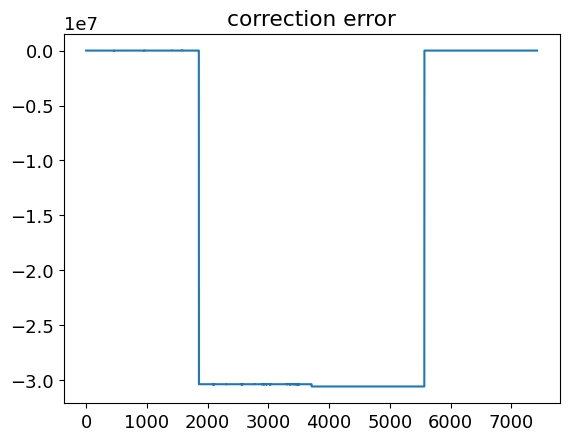

Beta beating before correction :
RMS horizontal beta beating:0.17823599553700323%   RMS vertical beta beating: 5.671258252684232%
Beta beating after corrections
RMS horizontal beta beating:0.1948092692915825%   RMS vertical beta beating: 7.580815695167123%
beta_x correction reduction -9.298499837053686
beta_x correction reduction -33.670789750741626
RMS horizontal orbit with optics correction: 2.4769961754433383 mu m,  RMS vertical orbit with optics correction: 2.162362765447973 mu m
Tune values with optics corrections: [214.26056681 214.3695207 ], The chromaticity values: [-0.06658237  0.42742332]. 


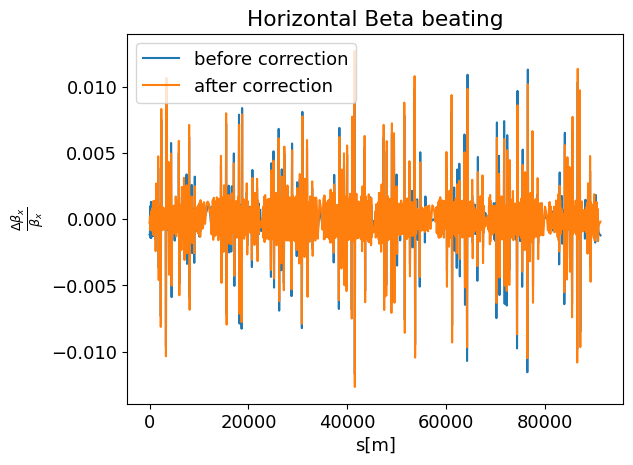

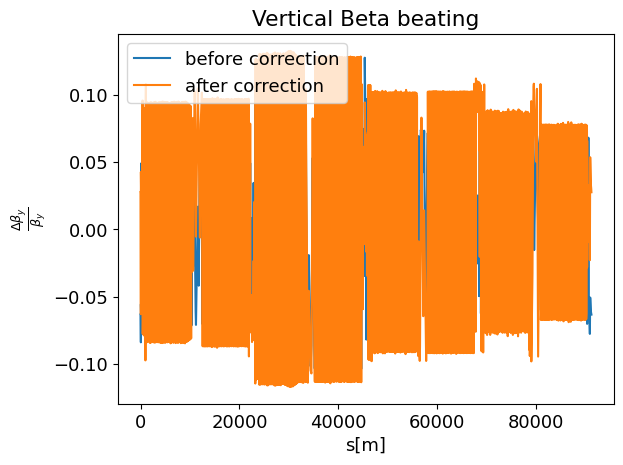


Fitting Tune...
Initial value [214.26056681 214.3695207 ]
iter# 0 Res. 3.203286611181835e-09
iter# 1 Res. 1.1211295166537075e-13
Final value [214.2602333 214.379906 ] 

 BPM_to_corrector_response_matrices (Measured) ..
LOCO iterations
Execution time: 559.3170146942139 sec


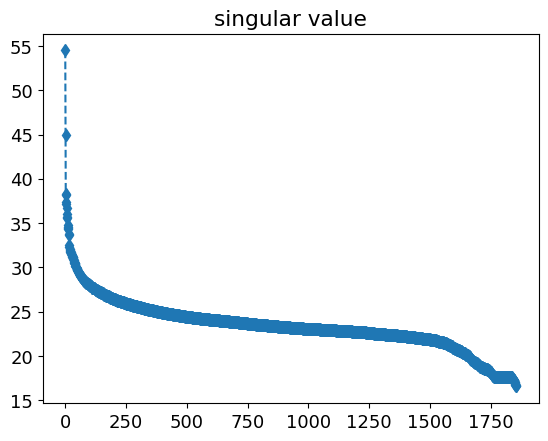

number of singular values 1856


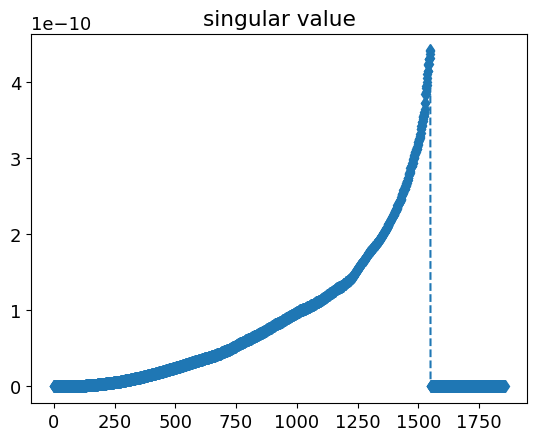

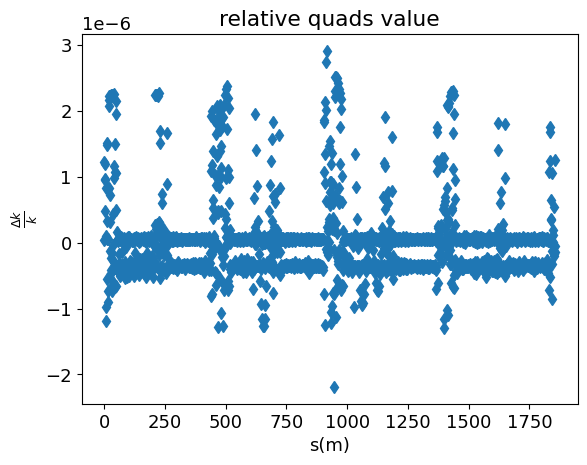

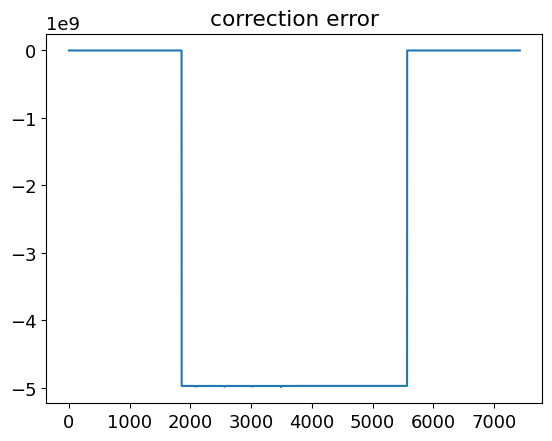

Beta beating before correction :
RMS horizontal beta beating:0.1945840002184869%   RMS vertical beta beating: 8.112261613677118%
Beta beating after corrections
RMS horizontal beta beating:0.19142007568869557%   RMS vertical beta beating: 14.705906206388597%
beta_x correction reduction 1.6259941856672455
beta_x correction reduction -81.27997969881444
RMS horizontal orbit with optics correction: 2.4771920992023047 mu m,  RMS vertical orbit with optics correction: 2.160860326614766 mu m
Tune values with optics corrections: [214.2600628  214.40732519], The chromaticity values: [0.14228907 0.55837154]. 


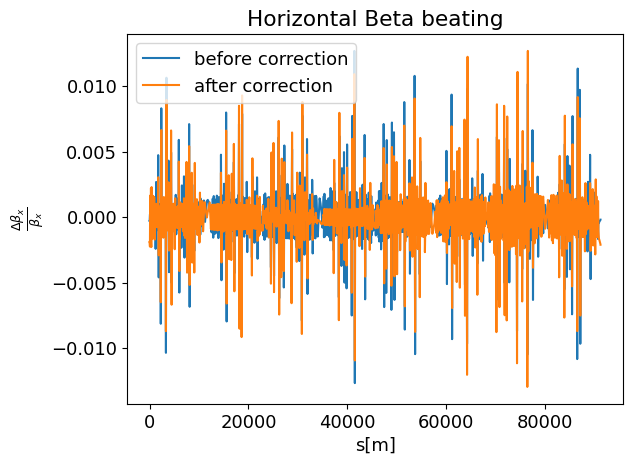

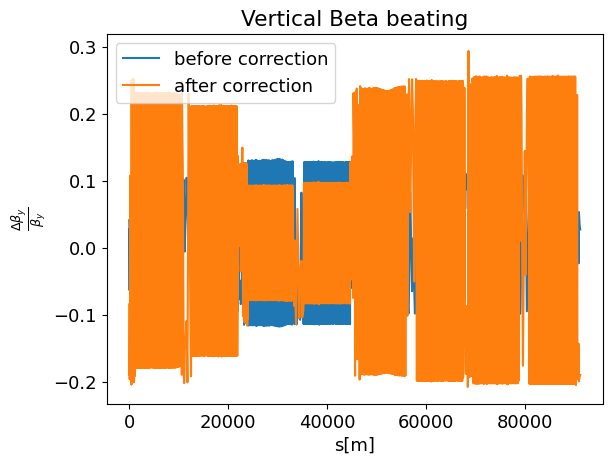

In [5]:
print('LOCO')
numberOfIteration = 3
for x in range(numberOfIteration):
    _, _, twiss_err = at.get_optics(ring, bpm_indices)
    fit_tune(ring, get_refpts(ring, 'QF*'),
    get_refpts(ring, 'QD*'),nominal_tune )
    print(" BPM_to_corrector_response_matrices (Measured) ..")
    Cx, Cxy, Cy, Cyx = ORMs(correctrs_kick, ring,used_cor_indices)
    bx_rms_err, by_rms_err = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
    print('LOCO iterations')
    t0 = time.time()
    A, B = defineJacobianMatrices(Cx0, Cy0, Cxy0, Cyx0, Cx, Cy, Cxy, Cyx, dCx, dCy, dCxy,dCyx)
    t1 = time.time()
    print(f"Execution time: {t1-t0} sec")
    np.save('A_{}.npy'.format(x), A)
    np.save('B_{}.npy'.format(x), B)
    Nk = len(dCx)
    r = getInverse(A, B, Nk, sCut, showPlots = 'True')
    setCorrection(ring, r , quads_indices)
    _, _, twiss_cor = at.get_optics(ring, bpm_indices)
    print('Beta beating before correction :')
    print("RMS horizontal beta beating:" + str(bx_rms_err * 100) + "%   RMS vertical beta beating: " + str(by_rms_err * 100) + "%")
    print('Beta beating after corrections')
    bx_rms_cor, by_rms_cor = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
    print("RMS horizontal beta beating:" + str(bx_rms_cor * 100) + "%   RMS vertical beta beating: " + str(by_rms_cor * 100) + "%")
    print('beta_x correction reduction', (1-bx_rms_cor/bx_rms_err)*100)
    print('beta_x correction reduction', (1-by_rms_cor/by_rms_err)*100)
    rmsx, rmsy = rms_orbits(ring, bpm_indices, makeplot = False)
    print(f"RMS horizontal orbit with optics correction: {rmsx*1.e6} mu m, ", f"RMS vertical orbit with optics correction: {rmsy*1.e6} mu m")
    print(f"Tune values with optics corrections: {get_tune(ring, get_integer=True)}, "
          f"The chromaticity values: {get_chrom(ring)}. ")
    corrections_plots(ring ,twiss, twiss_err, 'beta')

In [6]:
r

array([ 1.22952864e-06,  4.26698104e-08,  4.75223711e-07, ...,
       -5.30600471e-08, -1.48430538e-07,  1.25085416e-06])

In [7]:
A

array([[5.30218877e+10, 2.77697618e+11, 9.25458489e+11, ...,
        9.43003993e+11, 2.88849197e+11, 5.63725264e+10],
       [2.77697618e+11, 1.45452851e+12, 4.84751847e+12, ...,
        4.94134555e+12, 1.51361483e+12, 2.95423463e+11],
       [9.25458489e+11, 4.84751847e+12, 1.61555366e+13, ...,
        1.64706470e+13, 5.04528272e+12, 9.84753671e+11],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [8]:
B

array([[ -1985073.42779164],
       [-10492628.89833047],
       [-35088279.38371805],
       ...,
       [        0.        ],
       [        0.        ],
       [        0.        ]])

In [9]:
dCx

array([[[  -999.71393482,  -1938.64805054,  -3286.27655927, ...,
           1847.95294552,    950.97387199,    648.03539987],
        [  -837.64795067,  -1624.36951859,  -2753.53111556, ...,
           1548.41291319,    796.82791984,    542.99373486],
        [  -767.88008773,  -1489.07553985,  -2524.18913708, ...,
           1419.45545714,    730.46523665,    497.77131782],
        ...,
        [   311.40680835,    603.88068489,   1023.66114941, ...,
           -575.59536273,   -296.20661493,   -201.84805345],
        [  -195.22626464,   -378.58376102,   -641.75204559, ...,
            360.92982725,    185.73810556,    126.57036991],
        [   950.97379436,   1844.13166228,   3126.05851059, ...,
          -1757.93918248,   -904.65228778,   -616.47020436]],

       [[ -5190.9776574 ,  -9944.5392098 , -16858.16928443, ...,
           9694.38773267,   4989.72591226,   3401.19624593],
        [ -4345.5878978 ,  -8325.05630268, -14112.79126985, ...,
           8115.57995323,   4177.10929

theta=0
found DA 16.5 0.0
DA radius is 16.5
theta=10
found DA 16.249327924701433 2.8651949315043503
DA radius is 16.5
theta=20
found DA 15.974774553360444 5.814342436536368
DA radius is 17.0
theta=30
found DA 16.021469970012117 9.249999999999998
DA radius is 18.5
theta=40
found DA 16.086933305498537 13.498539803417325
DA radius is 21.0
theta=50
found DA 15.748296437320214 18.768088856414963
DA radius is 24.5
theta=60
found DA 15.500000000000004 26.846787517317598
DA radius is 31.0
theta=70
found DA 15.390906449655096 42.286167935365874
DA radius is 45.0
theta=80
found DA 14.325974657521758 81.24663962350716
DA radius is 82.5
theta=90
found DA 7.409113134841488e-15 121.0
DA radius is 121.0
theta=100
found DA -14.586446924022145 82.72385125302547
DA radius is 84.0
theta=110
found DA -15.390906449655093 42.28616793536588
DA radius is 45.0
theta=120
found DA -15.499999999999993 26.8467875173176
DA radius is 31.0
theta=130
found DA -15.748296437320214 18.768088856414963
DA radius is 24.5
th

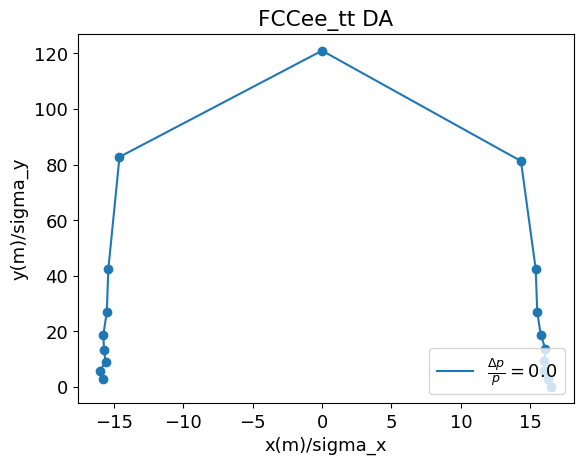

Execution time: 1263.7732939720154 sec


In [10]:
print("Dynamic Aperture calculation - with correction")
x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'with_correction',showPlot=True, debug=True)